<a href="https://colab.research.google.com/github/PongsakornChuneyoo/hello-world/blob/master/Test7%E0%B8%AA%E0%B8%B3%E0%B9%80%E0%B8%99%E0%B8%B2%E0%B8%82%E0%B8%AD%E0%B8%87_%E0%B8%AA%E0%B8%A3%E0%B9%89%E0%B8%B2%E0%B8%87_%E0%B9%82%E0%B8%A1%E0%B9%80%E0%B8%94%E0%B8%A5_AI_%E0%B8%88%E0%B8%B2%E0%B8%81_voc_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

PASCAL-VOC Detection model Training

refer ; https://github.com/AIWintermuteAI/aXeleRate?fbclid=IwAR0qOevlKD1pVGtVhbGZqUiQmCTFArqEYaepNMsJnaptNUmBhU_Dr-UJfFg

update 22/12/64

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


เริ่มต้นด้วยโหลดไลบรารี่ต่างที่เกี่ยววข้อง

In [2]:
!pip uninstall -y imgaug && pip uninstall -y albumentations && pip install imgaug==0.4
!git clone -b legacy-yolov2 https://github.com/AIWintermuteAI/aXeleRate.git
import sys
sys.path.append('/content/aXeleRate')
from axelerate import setup_training, setup_inference

Found existing installation: imgaug 0.4.0
Uninstalling imgaug-0.4.0:
  Successfully uninstalled imgaug-0.4.0
Found existing installation: albumentations 1.2.1
Uninstalling albumentations-1.2.1:
  Successfully uninstalled albumentations-1.2.1
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 948 kB 4.1 MB/s 
Cloning into 'aXeleRate'...
remote: Enumerating objects: 2404, done.
remote: Counting objects: 100% (225/225), done.
remote: Compressing objects: 100% (49/49), done.
remote: Total 2404 (delta 201), reused 178 (delta 176), pack-reused 2179
Receiving objects: 100% (2404/2404), 9.66 MiB | 32.74 MiB/s, done.
Resolving deltas: 100% (1577/1577), done.


โหลดไฟล์ จากไดร์
- ตัวอย่างแยกหมา กับ แมว : 
      1pZOfpsMyxqz1e6PS4TIyp9uW922791HF
      14A0COuMAprA-sMRz_FftuijWLxsjLVwO





In [3]:
%matplotlib inline
!gdown https://drive.google.com/uc?id=1FQMVrUbRgK1Jm3qhuSbiipXV53CCuXGW  #pascal-voc dataset 

!unzip --qq JPEGImages.zip # unzip ไฟล์ ในไฟล์ตัวอย่างจะชื่อ cat_dog.zip ซึ่งเป็นไฟที่ได้โหลดมาจากไดร์

Downloading...
From: https://drive.google.com/uc?id=1FQMVrUbRgK1Jm3qhuSbiipXV53CCuXGW
To: /content/JPEGImages.zip
100% 10.5M/10.5M [00:01<00:00, 8.65MB/s]


In [4]:
%matplotlib inline
!gdown https://drive.google.com/uc?id=1STygrok6Ia8E-b8ml5dSc7VXk8lgE_u5  #pascal-voc dataset 

!unzip --qq Annotations.zip # unzip ไฟล์ ในไฟล์ตัวอย่างจะชื่อ cat_dog.zip ซึ่งเป็นไฟที่ได้โหลดมาจากไดร์

Downloading...
From: https://drive.google.com/uc?id=1STygrok6Ia8E-b8ml5dSc7VXk8lgE_u5
To: /content/Annotations.zip
100% 619k/619k [00:00<00:00, 136MB/s]


นำไฟล์ที่โหลดมา แสดงเป็นตัวอย่าง
- ในตำแหน่ง img_folder='/content/JPEGImages' ต้องแก้ไข JPEGImages ให้ตรงกับชื่อไฟล์ที่เก็บรูป
- ในตำแหน่ง ann_folder='/content/Annotations' ต้องแก้ไข Annotations ให้ตรงกับชื่อไฟล์ที่เก็บ Data 

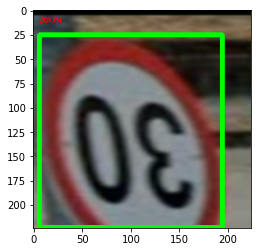

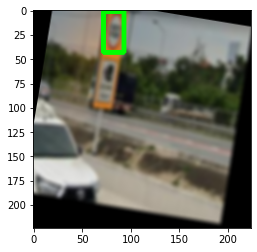

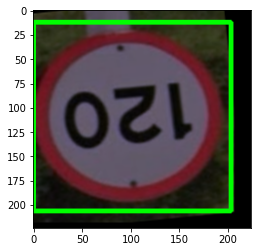

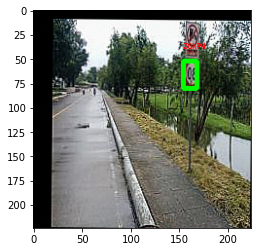

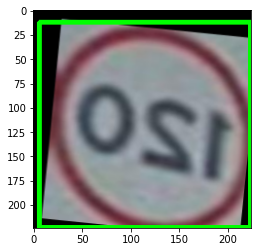

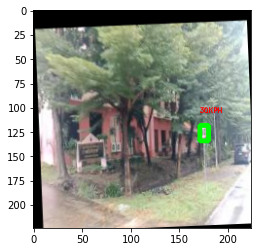

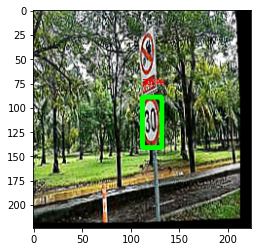

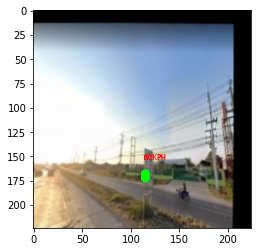

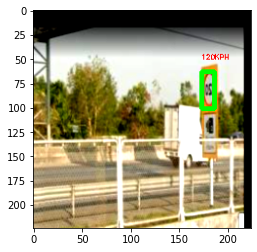

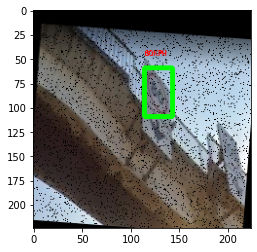

In [8]:
from axelerate.networks.common_utils.augment import visualize_detection_dataset
visualize_detection_dataset(img_folder='/content/JPEGImages', ann_folder='/content/Annotations', num_imgs=10, img_size=224, augment=True)

In [9]:
import os
def createFolder(directory):
    try:
        if not os.path.exists(directory):
            os.makedirs(directory)
    except OSError:
        print ('Error: Creating directory. ' +  directory)

สร้าง โฟร์เดอร์ ขึ้นมาใหม่เพื่อ ใช้สำหรับเก็บรูปและData สำหรับ test 


In [10]:
createFolder('/content/annotations_v/')
createFolder('/content/images_v/')

คัดรูป และ Data ไปใส่ที่โฟร์เดอร์ที่สร้างขึ้นใหม่ ใช้สำหรับ test

ส่วนใหญ่แล้วจะใช้รูปสำหรับ test ที่ 30% 
- ในบรรทัด files = files[0:90] ตัวเลข 90 คือจำนวนที่ต้องการแยกออกมา

ตัวอย่างเช่น มีรูปทั้งหมด 500 รูป 30% จะได้ 150
- จะได้ files = files[0:150]

ตำแหน่ง 
- imgSrc ที่อยู่โฟร์เดอร์รูป ทั้งหมด
- imgTarget ที่อยู่โฟร์เดอร์รูป ที่คัดออกมา ใช้สำหรับ test
- annoSrc ที่อยู่โฟร์เดอร์ Data ทั้งหมด
-  annoTarget ที่อยู่โฟร์เดอร์ Data ที่คัดออกมา ใช้สำหรับ test

In [11]:
import os, random, shutil
files = os.listdir("/content/JPEGImages/")
random.shuffle(files)
files = files[0:280]
for file in files:
    imgSrc = "/content/JPEGImages/" + file
    imgTarget = "/content/images_v/" + file
    annoSrc = "/content/Annotations/" + os.path.splitext(file)[0] + ".xml"
    annoTarget = "/content/annotations_v/" + os.path.splitext(file)[0] + ".xml"
    shutil.move(imgSrc,imgTarget)
    shutil.move(annoSrc,annoTarget)

Type is model frontend - Classifier, Detector or Segnet

Architecture is model backend (feature extractor) 

- MobileNet1_0
- MobileNet7_5 
- MobileNet5_0 
- MobileNet2_5 

ในตำแหน่ง labels ใน ["dog", "cat"] สามารถแก้ใขให้ตรงกับ dataset ที่ทำมาก่อนหน้า

ในตำแหน่ง actual_epoch คือจำนวนรอบในการ train

train_image_folder ใส่ตำแหน่งที่อยู่โฟร์เดอร์รูปสำหรับ train

train_annot_folder ใส่ตำแหน่งที่อยู่โฟร์เดอร์ Data สำหรับ train

valid_image_folder ใส่ตำแหน่งที่อยู่โฟร์เดอร์รูปสำหรับ test

valid_annot_folder ใส่ตำแหน่งที่อยู่โฟร์เดอร์ Data สำหรับ train



In [14]:
config = {
        "model":{
            "type":                 "Detector",
            "architecture":         "MobileNet1_0",
            "input_size":           224,
            "anchors":              [0.57273, 0.677385, 1.87446, 2.06253, 3.33843, 5.47434, 7.88282, 3.52778, 9.77052, 9.16828],
            "labels":               ["30KPH","80KPH","120KPH"],
            "coord_scale" : 		1.0,
            "class_scale" : 		1.0,
            "object_scale" : 		5.0,
            "no_object_scale" : 	1.0
        },
        "weights" : {
            "full":   				"",
            "backend":   		    "imagenet"
        },
        "train" : {
            "actual_epoch":         5000,
            "train_image_folder":   "/content/JPEGImages",
            "train_annot_folder":   "/content/Annotations",
            "train_times":          1,
            "valid_image_folder":   "/content/images_v",
            "valid_annot_folder":   "/content/annotations_v",
            "valid_times":          1,
            "valid_metric":         "mAP",
            "batch_size":          32,
            "learning_rate":        0.0004,
            "saved_folder":   		"/content/MODEL",
            "first_trainable_layer": "",
            "augumentation":				False,
            "is_only_detect" : 		False
        },
        "converter" : {
            "type":   				["k210"]
        }
    }

In [15]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 16950678165225063500
 xla_global_id: -1, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 16139419648
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 7688382611240467832
 physical_device_desc: "device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0"
 xla_global_id: 416903419]

In [ ]:
from keras import backend as K 
K.clear_session()
model_path = setup_training(config_dict=config)

Project folder /content/MODEL is created.
7528448/7513544 [==============================] - 0s 0us/step
/content/aXeleRate/axelerate/networks/common_utils/ncc_linux_x86_64.tar.xz
['30KPH', '80KPH', '120KPH']
17235968/17225924 [==============================] - 0s 0us/step
Successfully loaded imagenet backend weights
Failed to load pre-trained weights for the whole model. It might be because you didn't specify any or the weight file cannot be found
Current training session folder is /content/MODEL/2022-09-14_05-20-57


Model: "yolo"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1_pad (ZeroPadding2D)   (None, 226, 226, 3)       0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


                                                                 
 conv_pw_5_bn (BatchNormaliz  (None, 28, 28, 256)      1024      
 ation)                                                          
                                                                 
 conv_pw_5_relu (ReLU)       (None, 28, 28, 256)       0         
                                                                 
 conv_pad_6 (ZeroPadding2D)  (None, 30, 30, 256)       0         
                                                                 
 conv_dw_6 (DepthwiseConv2D)  (None, 14, 14, 256)      2304      
                                                                 
 conv_dw_6_bn (BatchNormaliz  (None, 14, 14, 256)      1024      
 ation)                                                          
                                                                 
 conv_dw_6_relu (ReLU)       (None, 14, 14, 256)       0         
                                                                 
 conv_pw_6

/content/aXeleRate/axelerate/networks/common_utils/fit.py:129: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  use_multiprocessing = True)


Epoch 1/5000
26/26 [==============================] - ETA: 0s - loss: 2.4180

/content/aXeleRate/axelerate/networks/yolo/backend/batch_gen.py:85: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return imgs_list, np.array(anns_list)


เอาต์พุตของการสตรีมมีการตัดเหลือเพียง 5000 บรรทัดสุดท้าย
Epoch 00221: Learning rate is 0.00039810795799180706.

26/26 [==============================] - 28s 1s/step - loss: 0.2720 - val_loss: 0.6199
Epoch 223/5000
26/26 [==============================] - ETA: 0s - loss: 0.2503

30KPH 0.5316
80KPH 0.3946
120KPH 0.5141
mAP: 0.4801
mAP did not improve from 0.5009591239582805.
Epoch 00222: Learning rate is 0.00039809066418365337.

26/26 [==============================] - 27s 1s/step - loss: 0.2503 - val_loss: 0.5509
Epoch 224/5000
26/26 [==============================] - ETA: 0s - loss: 0.2681

30KPH 0.5097
80KPH 0.3429
120KPH 0.4938
mAP: 0.4488
mAP did not improve from 0.5009591239582805.
Epoch 00223: Learning rate is 0.00039807329207851435.

26/26 [==============================] - 28s 1s/step - loss: 0.2681 - val_loss: 0.6239
Epoch 225/5000
26/26 [==============================] - ETA: 0s - loss: 0.2537

30KPH 0.5260
80KPH 0.3909
120KPH 0.4729
mAP: 0.4633
mAP did not improve from 0.5009

/content/aXeleRate/axelerate/networks/yolo/backend/decoder.py:57: RuntimeWarning: overflow encountered in exp
  return 1. / (1. + np.exp(-x))




30KPH 0.0000
80KPH 0.0000
120KPH 0.0361
mAP: 0.0120
mAP did not improve from 0.560799582812712.
Epoch 00676: Learning rate is 0.00038231341836602467.

26/26 [==============================] - 28s 1s/step - loss: 0.5716 - val_loss: 3.2213
Epoch 678/5000
26/26 [==============================] - ETA: 0s - loss: 0.5273

30KPH 0.1023
80KPH 0.0303
120KPH 0.0416
mAP: 0.0581
mAP did not improve from 0.560799582812712.
Epoch 00677: Learning rate is 0.00038226168451717613.

26/26 [==============================] - 28s 1s/step - loss: 0.5273 - val_loss: 2.2045
Epoch 679/5000
26/26 [==============================] - ETA: 0s - loss: 0.3619

30KPH 0.2544
80KPH 0.1682
120KPH 0.2199
mAP: 0.2142
mAP did not improve from 0.560799582812712.
Epoch 00678: Learning rate is 0.0003822098786278784.

26/26 [==============================] - 28s 1s/step - loss: 0.3619 - val_loss: 1.1226
Epoch 680/5000
26/26 [==============================] - ETA: 0s - loss: 0.3037

30KPH 0.2356
80KPH 0.1857
120KPH 0.3051
mAP: 